<a href="https://colab.research.google.com/github/nguyen2001ag/IoT_Website/blob/master/Plant_Diseases_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tf-nightly

     |████████████████████████████████| 324.4MB 52kB/s 
     |████████████████████████████████| 11.6MB 54.5MB/s 
     |████████████████████████████████| 460kB 56.4MB/s 


In [2]:
import cv2
import numpy as np
import pandas as pd

from collections import Counter

import tensorflow as tf

import keras
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout 
from tensorflow.keras.applications import MobileNetV2, InceptionV3, DenseNet121
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook as tqdm

import random

import matplotlib.pyplot as plt


In [3]:
import io 
import os.path

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
## Downloading file from Google Drive

#download = drive.CreateFile({'id': '1Kuz9LVt9nxFghTwDeo9csu0lnNdIbmu8'})
#download.GetContentFile('data.tar.gz')

download = drive.CreateFile({'id': '1z7IwGSpXTGrhp_1DoIU6ugjLWGwW5m6S'})
download.GetContentFile('color.rar')


In [ ]:
data_file = drive.CreateFile({'id' :'1Lpevmx3aA_csR93eTcWKb7TSK9QoqM2W'})
data_file.GetContentFile('bing_results.csv')

In [ ]:
from pyunpack import Archive
Archive('color.rar').extractall('./')

In [ ]:
!ls

drive  sample_data


In [ ]:
#df = pd.read_csv(io.BytesIO(uploaded['data.csv']))
df = pd.read_csv('bing_results.csv',encoding = 'utf-8')

In [ ]:
df.loc[28:32]

In [8]:
data_dir = '/content/drive/My Drive/color'


In [10]:
#Loading data using image_dataset_from_directory

data_dir = '/content/drive/My Drive/color'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  label_mode= 'categorical',
  seed=123,
  image_size=(256, 256),
  shuffle = True,
  batch_size= 64)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  label_mode= 'categorical',
  seed=123,
  image_size=(256, 256),
  shuffle = True,
  batch_size= 64)




Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.


In [13]:
#Testing with less data

data_dir = '/content/drive/My Drive/color_test'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  label_mode= 'categorical',
  seed=123,
  image_size=(256, 256),
  shuffle = True,
  batch_size= 64)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  label_mode= 'categorical',
  seed=123,
  image_size=(256, 256),
  shuffle = True,
  batch_size= 64)


Found 3171 files belonging to 4 classes.
Using 2537 files for training.
Found 3171 files belonging to 4 classes.
Using 634 files for validation.


In [11]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(len(class_names))

'''
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
'''

38


'\nAUTOTUNE = tf.data.experimental.AUTOTUNE\n\ntrain_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)\nval_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)\n'

In [ ]:
# DRAW OUT DATA FOR VISUALIZATION

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(images[i]).astype("uint8"))
    plt.title(class_names[int(np.where(np.array(labels[i]) == 1)[0])])
    plt.axis("off")



In [19]:
train_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None, 4)), types: (tf.float32, tf.float32)>

In [9]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

#train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 


0.0 0.82745105


In [ ]:
#AUTOTUNE = tf.data.experimental.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
os.listdir('/content/drive/My Drive/data_distribution_for_SVM')

['test_mapping.txt', 'train_mapping.txt', 'train', 'test']

In [ ]:
#Using ImageDataGenerator

train_root = '/content/drive/My Drive/data_distribution_for_SVM/train'
val_root = '/content/drive/My Drive/data_distribution_for_SVM/test'


datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# load and iterate training dataset
train_ds = datagen.flow_from_directory(train_root, class_mode='categorical', batch_size=64)
# load and iterate validation dataset
val_ds = datagen.flow_from_directory(val_root, class_mode='categorical', batch_size=64)


Found 8751 images belonging to 38 classes.
Found 10547 images belonging to 38 classes.


In [ ]:
!pip install d2l==0.14.2
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6

In [ ]:
#GoogleNet Neural Network


In [13]:
clear_session()

tf.random.set_seed(0)

img = Input(shape = (256, 256, 3))

## You can replace DenseNet121 with MobileNet, Xception or ResNet50
model = ResNet50(include_top=False, 
                    weights='imagenet', 
                    input_tensor=img, 
                    input_shape=None, 
                    pooling='avg')


#updated_model = Sequential()

#count = 0

#for layer in model.layers:
#  count += 1
#  updated_model.add(layer)
#  if (count > int(len(model.layers)*0.5)):
#      updated_model.add(Dropout(.1))

#model = updated_model

#[int(len(model.layers) * 0.8) : ]
#model.layers.trainable = True
for layer in model.layers:
  layer.trainable = False

for layer in model.layers[int(0.95 * len(model.layers)):]:
  layer.trainable = True


final_layer = model.layers[-1].output

print(final_layer.shape)

final_layer = Dropout(0.1, seed = 1)(final_layer)

#dense_layer_1 = Dense(128, activation = 'relu')(final_layer)
#dense_layer_1 = Dropout(0.1, seed = 1)(dense_layer_1)


#dense_layer_2 = Dense(128, activation = 'relu')(dense_layer_1)
#dense_layer_2 = Dropout(0.1, seed = 1)(dense_layer_2)

output_layer = Dense(38, activation = 'softmax')(final_layer)


model = Model(inputs = img, outputs = output_layer)


94773248/94765736 [==============================] - 1s 0us/step
(None, 2048)


In [ ]:
#loss_fn = tf.nn.softmax_cross_entropy_with_logits()
#(from_logits= True)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum= 0.9), loss = loss_fn , metrics = ['accuracy'])
model.summary()

In [50]:
## Custom callback to compute F1 Score and save the model
## with best validation F1 Score.

class ComputeF1(Callback):
    
    def __init__(self):
        self.best_f1 = -1
        
    def on_epoch_end(self, epoch, logs={}):
        if val_f1 > self.best_f1:
            print('Better F1 Score, Saving model...')
            export_path = "/content/drive/My Drive/Plant_Diseases_Model"
            self.model.save(export_path, save_format='tf')
            self.best_f1 = val_f1

f1_score_callback = ComputeF1()

In [ ]:
# Mini-batch

#BATCH_SIZE = 32
#SHUFFLE_BUFFER_SIZE = 1000

#train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
#validation_batches = validation.batch(BATCH_SIZE)
#test_batches = test.batch(BATCH_SIZE)

In [ ]:
history = model.fit(train_ds, epochs = 20, validation_data = val_ds)
#model.fit(trainX, trainY, batch_size = 32, epochs = 25, validation_data = (valX, valY), callbacks = [f1_score_callback])

export_path = "/content/drive/My Drive/Plant_Diseases_Model_2"
model.save(export_path, save_format='tf')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Epoch 1/20
 59/679 [=>............................] - ETA: 3:22:54 - loss: 1.2813 - accuracy: 0.6764

In [1]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

NameError: ignored

In [5]:
## Loading best model based on validation score

from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/Plant_Diseases_Model')

In [55]:
def F1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='samples')

--------------------------What the Model Predict--------------------------
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Target_Spot
Tomato___Target_Spot


TypeError: ignored

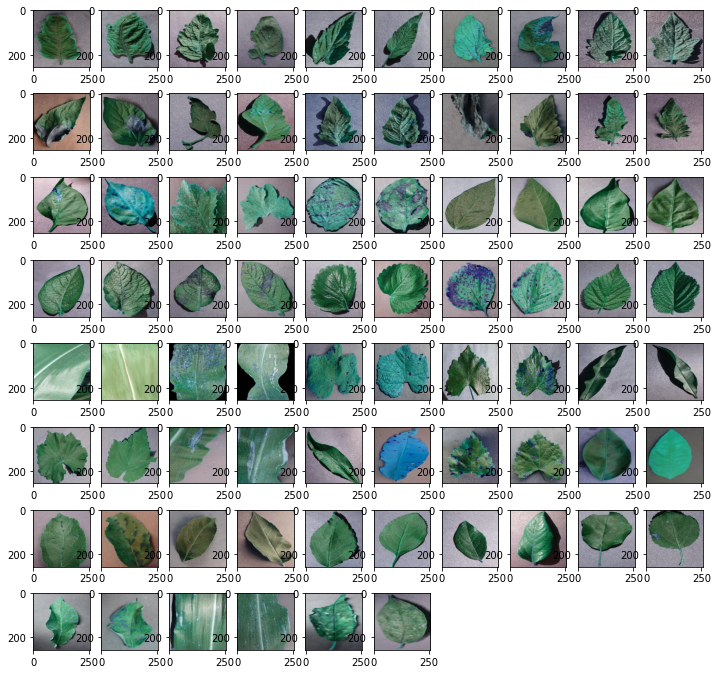

In [12]:
val_classes = os.listdir(data_dir)


plt.figure(figsize=(12, 12))
'''
some_img1 = data_dir + '/' +val_classes[0] + '/' + os.listdir(data_dir + '/' +val_classes[0])[0]
some_img1 = np.array(cv2.imread(some_img1)).astype("uint8")
some_img2 = data_dir + '/' +val_classes[0] + '/' + os.listdir(data_dir + '/' +val_classes[0])[1]
some_img2 = np.array(cv2.imread(some_img2)).astype("uint8")
plt.subplot(1,2,1)
plt.imshow(some_img1)
plt.subplot(1,2,2)
plt.imshow(some_img2)
img_batch = np.array([some_img1, some_img2])
print(img_batch.shape)
print(model.predict(img_batch))
'''

imgs = []
count = 0

for val_class in val_classes:
  val_dir = data_dir + '/' + val_class
  for img in os.listdir(val_dir)[:2]:
    count += 1
    img_dir = val_dir + '/' + img
    test_img = cv2.imread(img_dir)
    imgs.append(test_img) 
    ax = plt.subplot(8, 10, count )
    plt.imshow(np.array(test_img).astype("uint8"))  
    
imgs = np.array(imgs)

result = model.predict(imgs)
print("--------------------------What the Model Predict--------------------------")
for value in result:
  print(class_names[int(np.where(np.array(value) >=0.8)[0])])


In [ ]:
F1_score(testY, model.predict(testX).round())

In [ ]:
autoencoder.save_weights('model_weights.h5')